# An Application of Online EM Algorithm to Letter Prediction Problem

The implementation of HMM in large part belongs to Ali Taylan Cemgil(ATC): 
https://github.com/atcemgil/notes/blob/master/HiddenMarkovModel.ipynb

The code importing the data also belongs to ATC: https://github.com/atcemgil/notes/blob/master/Sampling.ipynb

## An Implementation of HMM in Python

### Some Utility Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def randgen(pr, N=1): 
    L = len(pr)
    return np.random.choice(range(L), size=N, replace=True, p=pr)

def log_sum_exp(l, axis=0):
    l_star = np.max(l, axis=axis, keepdims=True)
    return l_star + np.log(np.sum(np.exp(l - l_star),axis=axis,keepdims=True)) 

def normalize_exp(log_P, axis=None):
    a = np.max(log_P, keepdims=True, axis=axis)
    P = normalize(np.exp(log_P - a), axis=axis)
    return P

def normalize(A, axis=None):
    Z = np.sum(A, axis=axis,keepdims=True)
    idx = np.where(Z == 0)
    Z[idx] = 1
    return A/Z


### Some HMM Functions

In [2]:
def predict(A, lp):
    lstar = np.max(lp)
    return lstar + np.log(np.dot(A,np.exp(lp-lstar)))

def postdict(A, lp):
    lstar = np.max(lp)
    return lstar + np.log(np.dot(np.exp(lp-lstar), A))

def update(y, logB, lp):
    return logB[y,:] + lp

### HMM Implementation 

In [3]:
class HMM(object):
    def __init__(self, pi, A, B):
        # p(x_0)
        self.pi = pi
        # p(x_k|x_{k-1})
        self.A = A
        # p(y_k|x_{k})
        self.B = B
        # Number of possible latent states at each time
        self.S = pi.shape[0]
        # Number of possible observations at each time
        self.R = B.shape[0]
        self.logB = np.log(self.B)
        self.logA = np.log(self.A)
        self.logpi = np.log(self.pi)
        
    def copy(self):
        pi_ = self.pi.copy()
        A_ = self.A.copy()
        B_ = self.B.copy()
        hmm = HMM(pi_,A_,B_)
        return hmm
    
    @classmethod
    def from_random_parameters(cls, S=3, R=5):
        A = np.random.dirichlet(0.7*np.ones(S),S).T
        B = np.random.dirichlet(0.7*np.ones(R),S).T
        pi = np.random.dirichlet(0.7*np.ones(S)).T
        return cls(pi, A, B)
    
    def eval_lhood(self,y):
        log_gamma = self.forward_backward_smoother(y)
        return log_sum_exp(log_gamma[:,0])
        
    def __str__(self):
        s = "Prior:\n" + str(self.pi) + "\nA:\n" + str(self.A) + "\nB:\n" + str(self.B)
        return s
    
    def __repr__(self):
        s = self.__str__()
        return s

    def predict(self, lp):
        lstar = np.max(lp)
        return lstar + np.log(np.dot(self.A,np.exp(lp-lstar)))

    def postdict(self, lp):
        lstar = np.max(lp)
        return lstar + np.log(np.dot(np.exp(lp-lstar), self.A))

    def update(self, y, lp):
        return self.logB[y,:] + lp

    def generate_sequence(self, T=10):
        # T: Number of steps
        x = np.zeros(T)
        y = np.zeros(T)

        for t in range(T):
            if t==0:
                x[t] = randgen(self.pi)
            else:
                x[t] = randgen(self.A[:,x[t-1]])    
            y[t] = randgen(self.B[:,x[t]])
    
        return y, x

    def forward(self, y):
        T = len(y)
        
        # Forward Pass

        # Python indexes starting from zero so
        # log \alpha_{k|k} will be in log_alpha[:,k-1]
        # log \alpha_{k|k-1} will be in log_alpha_pred[:,k-1]
        log_alpha  = np.zeros((self.S, T))
        log_alpha_pred = np.zeros((self.S, T))
        for k in range(T):
            if k==0:
                log_alpha_pred[:,0] = self.logpi
            else:
                log_alpha_pred[:,k] = self.predict(log_alpha[:,k-1])

            log_alpha[:,k] = self.update(y[k], log_alpha_pred[:,k])
            
        return log_alpha, log_alpha_pred
            
    def backward(self, y):
        # Backward Pass
        T = len(y)
        log_beta  = np.zeros((self.S, T))
        log_beta_post = np.zeros((self.S, T))

        for k in range(T-1,-1,-1):
            if k==T-1:
                log_beta_post[:,k] = np.zeros(self.S)
            else:
                log_beta_post[:,k] = self.postdict(log_beta[:,k+1])

            log_beta[:,k] = self.update(y[k], log_beta_post[:,k])

        return log_beta, log_beta_post
        
    def forward_backward_smoother(self, y):
        log_alpha, log_alpha_pred = self.forward(y)
        log_beta, log_beta_post = self.backward(y)
        
        log_gamma = log_alpha + log_beta_post
        return log_gamma
        
    def correction_smoother(self, y):
        # Correction Smoother

        log_alpha, log_alpha_pred = self.forward(y)
        T = len(y)
        
        # For numerical stability, we calculate everything in the log domain
        log_gamma_corr = np.zeros_like(log_alpha)
        log_gamma_corr[:,T-1] = log_alpha[:,T-1]

        C2 = np.zeros((self.S, self.S))
        C3 = np.zeros((self.R, self.S))
        C3[y[-1],:] = normalize_exp(log_alpha[:,T-1])
        for k in range(T-2,-1,-1):
            log_old_pairwise_marginal = log_alpha[:,k].reshape(1,self.S) + self.logA 
            log_old_marginal = self.predict(log_alpha[:,k])
            log_new_pairwise_marginal = log_old_pairwise_marginal + log_gamma_corr[:,k+1].reshape(self.S,1) - log_old_marginal.reshape(self.S,1)
            log_gamma_corr[:,k] = log_sum_exp(log_new_pairwise_marginal, axis=0).reshape(self.S)
            C2 += normalize_exp(log_new_pairwise_marginal)
            C3[y[k],:] += normalize_exp(log_gamma_corr[:,k])
        C1 = normalize_exp(log_gamma_corr[:,0])
        return C1, C2, C3, log_gamma_corr
    
    def forward_only_SS(self, y, V=None):
        # Forward only estimation of expected sufficient statistics
        T = len(y)
        
        if V is None:
            V1  = np.eye((self.S))
            V2  = np.zeros((self.S,self.S,self.S))
            V3  = np.zeros((self.R,self.S,self.S))
        else:
            V1, V2, V3 = V
            
        I_S1S = np.eye(self.S).reshape((self.S,1,self.S))
        I_RR = np.eye(self.R)
        
        for k in range(T):
            if k==0:
                log_alpha_pred = self.logpi
            else:
                log_alpha_pred = self.predict(log_alpha)

            if k>0:
                #print(self.S, self.R)
                #print(log_alpha)
                # Calculate p(x_{k-1}|y_{1:k-1}, x_k) 
                lp = np.log(normalize_exp(log_alpha)).reshape(self.S,1) + self.logA.T    
                P = normalize_exp(lp, axis=0)

                # Update
                V1 = np.dot(V1, P)             
                V2 = np.dot(V2, P) + I_S1S*P.reshape((1,self.S,self.S))    
                V3 = np.dot(V3, P) + I_RR[:,y[k-1]].reshape((self.R,1,1))*P.reshape((1,self.S,self.S))    

            log_alpha = self.update(y[k], log_alpha_pred)    
            p_xT = normalize_exp(log_alpha)    

        C1 = np.dot(V1, p_xT.reshape(self.S,1))
        C2 = np.dot(V2, p_xT.reshape(1,self.S,1)).reshape((self.S,self.S))
        C3 = np.dot(V3, p_xT.reshape(1,self.S,1)).reshape((self.R,self.S))
        C3[y[-1],:] +=  p_xT
        
        ll = log_sum_exp(log_alpha)
        
        return C1, C2, C3, ll, (V1, V2, V3)

    
    def train_EM(self, y, EPOCH=10, method=1):
        LL = np.zeros(EPOCH)
        for e in range(EPOCH):
            if method is 'correction_smoother':
                C1, C2, C3, log_gamma_corr = self.correction_smoother(y)
                ll = log_sum_exp(log_gamma_corr[:,0])
            elif method is 'forward_only':
                C1, C2, C3, ll, V = self.forward_only_SS(y)
            else:
                return
            LL[e] = ll
            p = normalize(C1 + 0.1, axis=0).reshape(self.S)
            # print(p,np.size(p))            
            A = normalize(C2+1e-10, axis=0)
            # print(A)
            B = normalize(C3+1e-10, axis=0)
            # print(B)
            self.__init__(p, A, B)
            
        return LL
    
    def online_em(self, y, V=None, n_min=100, gamma=0.2, gamma_const=0.999, log_interval=1e10):
        T = len(y)
        LL = np.zeros(T)
        
        if V is None:
            V1  = np.eye((self.S))
            V2  = np.zeros((self.S,self.S,self.S))
            V3  = np.zeros((self.R,self.S,self.S))
        else:
            V1, V2, V3 = V
            
        I_S1S = np.eye(self.S).reshape((self.S,1,self.S))
        I_RR = np.eye(self.R)
        
        for k in range(T):
            # log
            if np.mod(k,log_interval)==0: 
                log_gamma = self.forward_backward_smoother(y)
                print ("time={:d},\tlhood={:.4f}".format(k,log_sum_exp(log_gamma[:,0])[0])) 
                # print("time={:d}".format(k))
                # print(self.A)
                # print(self.B)
            # E step
            if k==0:
                log_alpha_pred = self.logpi
            else:
                log_alpha_pred = self.predict(log_alpha)

            if k>0:
                # Calculate p(x_{k-1}|y_{1:k-1}, x_k) 
                lp = np.log(normalize_exp(log_alpha)).reshape(self.S,1) + self.logA.T    
                P = normalize_exp(lp, axis=0)

                # Update
                V1 = np.dot(V1, P)             
                V2 = (1-gamma)*np.dot(V2, P) + gamma*I_S1S*P.reshape((1,self.S,self.S))    
                V3 = (1-gamma)*np.dot(V3, P) + gamma*I_RR[:,y[k-1]].reshape((self.R,1,1))*P.reshape((1,self.S,self.S))    

            log_alpha = self.update(y[k], log_alpha_pred)    
            p_xT = normalize_exp(log_alpha)    
        
            LL[k] = log_sum_exp(log_alpha)
            
            # M step
            if k > n_min:
                C1 = np.dot(V1, p_xT.reshape(self.S,1))
                C2 = np.dot(V2, p_xT.reshape(1,self.S,1)).reshape((self.S,self.S))
                C3 = np.dot(V3, p_xT.reshape(1,self.S,1)).reshape((self.R,self.S))
                C3[y[k],:] +=  p_xT
                
                p = normalize(C1+1e-10 + 0.1, axis=0).reshape(self.S)
                A = normalize(C2+1e-10, axis=0)
                B = normalize(C3+1e-10, axis=0)
                self.__init__(p, A, B)
            
            if gamma > 1e-3:
                gamma = np.min((0.2,np.power(k,-2/3)))
    
        return LL
    
    
            

### Test Code

In [4]:
import time
hmm_original = HMM.from_random_parameters()
L = 1000
y,x = hmm_original.generate_sequence(L)

# init three random HMM's with the sama parameters
hmm = HMM.from_random_parameters()

beg = time.time()
# train the second one with forward only SS
LL3 = hmm.online_em(y)
print ("online_em_lhood=%(lh).4f, duration=%(dur).4f" % {'lh':LL3[-1],'dur':time.time()-beg})

hmm_random = HMM.from_random_parameters()
print ("random lhood:%(lh).4f" % {'lh':hmm_random.eval_lhood(y)})

/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:64: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:63: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:52: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


time=0,	lhood=-1905.5308
online_em_lhood=-1642.2662, duration=0.2481
random lhood:-1752.1878


/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:256: RuntimeWarning: divide by zero encountered in power
/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:236: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:248: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [5]:
# init an hmm and generate data
import time
hmm_original = HMM.from_random_parameters()
L = 1000
y,x = hmm_original.generate_sequence(L)


beg = time.time()
# eval likelihood with the original params
LL = hmm_original.train_EM(y, EPOCH=50, method='correction_smoother')
print ("original_lhood=%(lh).4f, duration=%(dur).4f" % {'lh':LL[-1],'dur':time.time()-beg})
# plt.plot(LL)
# plt.show()

# init three random HMM's with the sama parameters
hmm1 = HMM.from_random_parameters()
hmm2 = hmm1.copy()
hmm3 = hmm1.copy()


beg = time.time()
# train the first one with correction smoother
LL1 = hmm1.train_EM(y, EPOCH=50, method='correction_smoother')
print ("correction_smoother_lhood=%(lh).4f, duration=%(dur).4f" % {'lh':LL1[-1],'dur':time.time()-beg})
# plt.plot(LL1)
# plt.show()

beg = time.time()
# train the second one with forward only SS
LL2 = hmm2.train_EM(y, EPOCH=50, method='forward_only')
print ("forward_only_ss_lhood=%(lh).4f, duration=%(dur).4f" % {'lh':LL2[-1],'dur':time.time()-beg})
# plt.plot(LL2)
# plt.show()
# print "hmm2:",hmm2,"\n"


beg = time.time()
# train the second one with forward only SS
LL3 = hmm3.online_em(y)
print ("online_em_lhood={:.4f}, duration={:.4f}".format(LL3[-1],time.time()-beg))
# plt.plot(LL3)
# plt.show()


hmm_random = HMM.from_random_parameters()
log_gamma = hmm_random.forward_backward_smoother(y)
print ("random_lhood={:.4f}".format(log_sum_exp(log_gamma[:,0])[0]) )

/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:64: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:63: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:52: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


original_lhood=-1416.1263, duration=4.8785
correction_smoother_lhood=-1417.7112, duration=4.7041

/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:123: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:130: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:164: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



forward_only_ss_lhood=-1417.7112, duration=4.5681

/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:172: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:256: RuntimeWarning: divide by zero encountered in power



time=0,	lhood=-1934.0327
online_em_lhood=-1702.9521, duration=0.2374
random_lhood=-1980.7228


/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:236: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:248: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Test Code - 2

In [6]:
hmm = HMM.from_random_parameters()

L = 300

y,x = hmm.generate_sequence(L)

print("Results with the Forward Smoother")
C1, C2, C3, ll, V = hmm.forward_only_SS(y)
    
print(C1)
print(np.sum(C1))

print(C2)
print(np.sum(C2))

print(C3)
print(np.sum(C3))

print("Results with the Correction Smoother")
C1_corr, C2_corr, C3_corr, lg = hmm.correction_smoother(y)

print(C1_corr)
print(np.sum(C1_corr))

print(C2_corr)
print(np.sum(C2_corr))

print(C3_corr)
print(np.sum(C3_corr))

/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:64: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:63: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:52: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:164: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:172: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Results with the Forward Smoother
[[ 0.00139411]
 [ 0.35422596]
 [ 0.64437993]]
1.0
[[ 20.7574196    8.97844269  69.15779745]
 [ 21.99096299  26.88024199  23.42969084]
 [ 56.08889013  36.76283636  34.95371795]]
299.0
[[  0.58901193  17.31974822   8.09123985]
 [ 71.06608287  16.65610592  19.27781121]
 [  7.09932239   3.31892508  78.58175253]
 [  7.80645238   0.69813351  16.49541412]
 [ 12.33418429  34.66220905   6.00360666]]
300.0
Results with the Correction Smoother
[ 0.00139411  0.35422596  0.64437993]
1.0
[[ 20.7574196    8.97844269  69.15779745]
 [ 21.99096299  26.88024199  23.42969084]
 [ 56.08889013  36.76283636  34.95371795]]
299.0
[[  0.58901193  17.31974822   8.09123985]
 [ 71.06608287  16.65610592  19.27781121]
 [  7.09932239   3.31892508  78.58175253]
 [  7.80645238   0.69813351  16.49541412]
 [ 12.33418429  34.66220905   6.00360666]]
300.0


/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:123: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:130: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# Data Sets

### Counting letter bigrams in several languages

In [7]:
%matplotlib inline
from collections import defaultdict
from urllib.request import urlopen
import string
import numpy as np
import matplotlib.pyplot as plt
import os

local = "file://"+os.getcwd()+"/data/"
print(local)
# local = 'file:///home/cagatay/hdd/Dropbox/Academic_Stuff/MyGithubRepos/bayesian/data/'
# Turkish
#"ç","ı","ğ","ö","ş","ü",'â'
# German
#"ä","ß","ö","ü"
# French
#"ù","û","ô","â","à","ç","é","è","ê","ë","î","ï","æ"
tr_alphabet = ['•','a','b','c','ç','d','e','f',
                'g','ğ','h','ı','i','j','k','l',
                'm','n','o','ö','p','q','r','s','ş',
                't','u','ü','w','v','x','y','z']
# Union of Frequent letters in French, Turkish, German and English
my_alphabet = ['•','a','â','ä',"à","æ",'b','c','ç','d','e',"é","è","ê","ë",'f',
                'g','ğ','h','ı','i',"î",'ï','j','k','l',
                'm','n','o','œ',"ô",'ö','p','q','r','s','ş',
                't','u','ù',"û",'ü','w','v','x','y','z','ß']
# Only ascii characters
ascii_alphabet = list('•'+string.ascii_lowercase)
# Reduction table from my alphabet to ascii
my2ascii_table = {
    ord('â'):"a",
    ord('ä'):"ae",
    ord("à"):"a",
    ord("æ"):"ae",
    ord('ç'):"c",
    ord("é"):"e",
    ord("è"):"e",
    ord("ê"):"e",
    ord("ë"):"e",
    ord('ğ'):"g",
    ord('ı'):"i",
    ord("î"):"i",
    ord('ï'):"i",
    ord('œ'):"oe",
    ord("ô"):"o",
    ord('ö'):"o",
    ord('ş'):"s",
    ord('ù'):"u",
    ord("û"):"u",
    ord('ü'):"u",
    ord('ß'):"ss"
    }
# Reduction table from my alphabet to frequent letters in turkish text
my2tr_table = {
    ord('â'):"a",
    ord('ä'):"ae",
    ord("à"):"a",
    ord("æ"):"ae",
    ord("é"):"e",
    ord("è"):"e",
    ord("ê"):"e",
    ord("ë"):"e",
    ord("î"):"i",
    ord('ï'):"i",
    ord('œ'):"oe",
    ord("ô"):"o",
    ord('ù'):"u",
    ord("û"):"u",
    ord('ß'):"ss"
    }


def count_transitions(fpp, alphabet, tab):

    #ignore punctuation
    tb = str.maketrans(".\t\n\r ","•••••", '0123456789!©¦„"\'™#$%&()*,-/:;<=>?@§[\\]^£‘_■`{|}~+')
    #replace other unicode characters with a bullet (alt-8)
    tbu = {
        ord("İ"):'i',
        ord(u"»"):'•', 
        ord(u"«"):'•', 
        ord(u"°"):'•', 
        ord(u"…"):'•',
        ord(u"”"):'•',
        ord(u"’"):'•',
        ord(u"“"):'•',
        ord(u"\ufeff"):'•',
        775: None}

    # Character pairs 
    DD = defaultdict(int)
    # Character triplets
    DDD = defaultdict(int)
    
    full_text = ""
    for line in fpp:
        s = line.decode('utf-8').translate(tb).lower()
        s = s.translate(tbu)
        s = s.translate(tab)
        # print(s)
        full_text += s

        if len(s)>1:
            for i in range(len(s)-1):
                DD[s[i:i+2]]+=1
                if i < len(s)-2: DDD[s[i:i+3]]+=1
                    
    
    a2i = {v: k for k,v in enumerate(alphabet)}
    data = np.zeros(len(full_text),dtype='int')
    for i in range(len(full_text)):
        data[i] = a2i[full_text[i]]
    
    M = len(alphabet)
    
    A2 = np.zeros((M,M))
    for k in DD.keys():
        i = a2i[k[0]]
        j = a2i[k[1]]
        A2[i,j] = DD[k]
    
    A3 = np.zeros((M,M,M))
    for t in DDD.keys():
        i = a2i[t[0]]
        j = a2i[t[1]]
        k = a2i[t[2]]
        A3[i,j,k] = DDD[t]

    return data, A2, A3


file:///home/cagatay/Dropbox/Academic_Stuff/MyGithubRepos/bayesian/data/


### Count and display occurences of letters in text

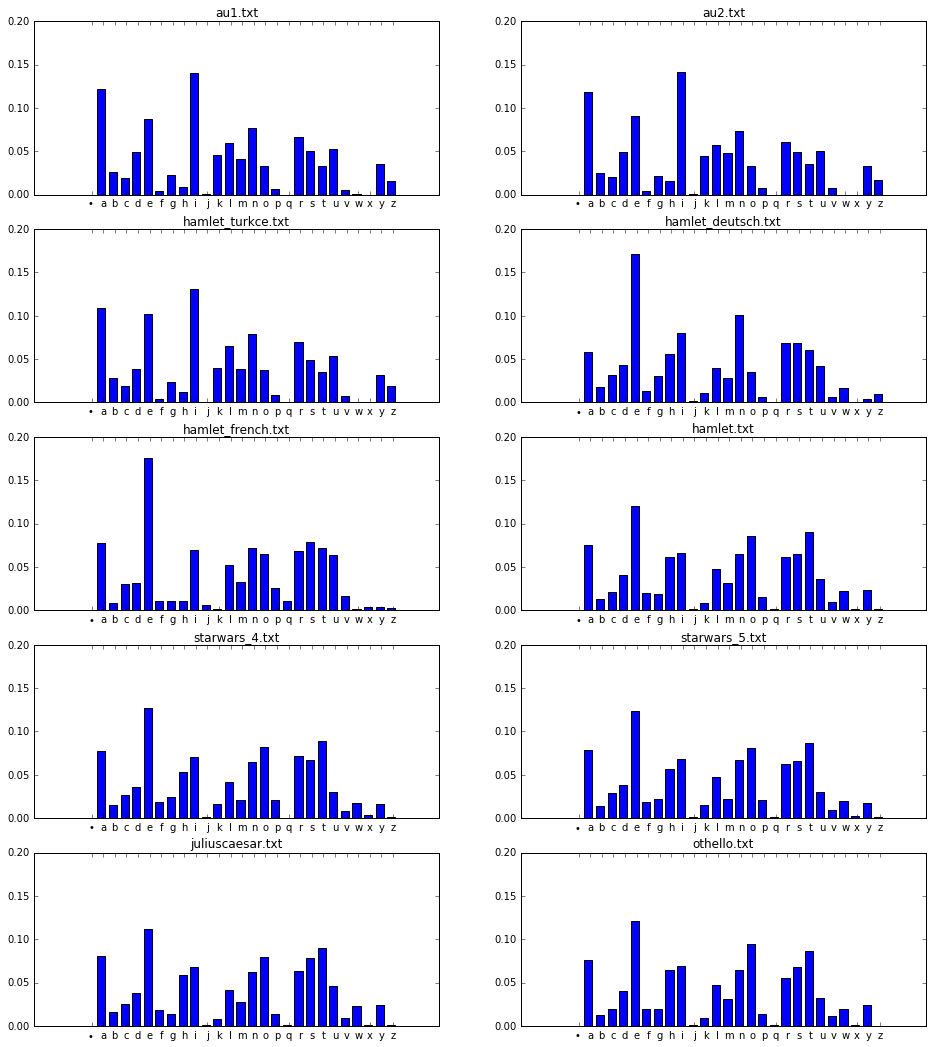

In [8]:
files = ['au1.txt','au2.txt','hamlet_turkce.txt','hamlet_deutsch.txt', 'hamlet_french.txt', 'hamlet.txt','starwars_4.txt', 'starwars_5.txt','juliuscaesar.txt','othello.txt']

plt.figure(figsize=(16,18))

i = 0
for f in files:
    url = local+f
    data = urlopen(url) 
    alphabet = ascii_alphabet
    #D, DD, alphabet = count_transitions(data, my_alphabet, {})
    data, DD, DDD = count_transitions(data, alphabet, my2ascii_table)
    
    #D, DD, alphabet = count_transitions(data, tr_alphabet, my2tr_table)
    M = len(alphabet)
    # Ignore space, space transitions
    DD[0,0] = 1
    
    i+=1
    plt.subplot(len(files)/2,2,i)
        
    S = np.sum(DD,axis=0)
    #Subpress spaces
    S[0] = 0
    S = S/np.sum(S)

    plt.bar(np.arange(M)-0.5, S, width=0.7)
    plt.xticks(range(M), alphabet)
    plt.gca().set_ylim((0,0.2))
    plt.title(f)

plt.show()


### Counting Bigrams 

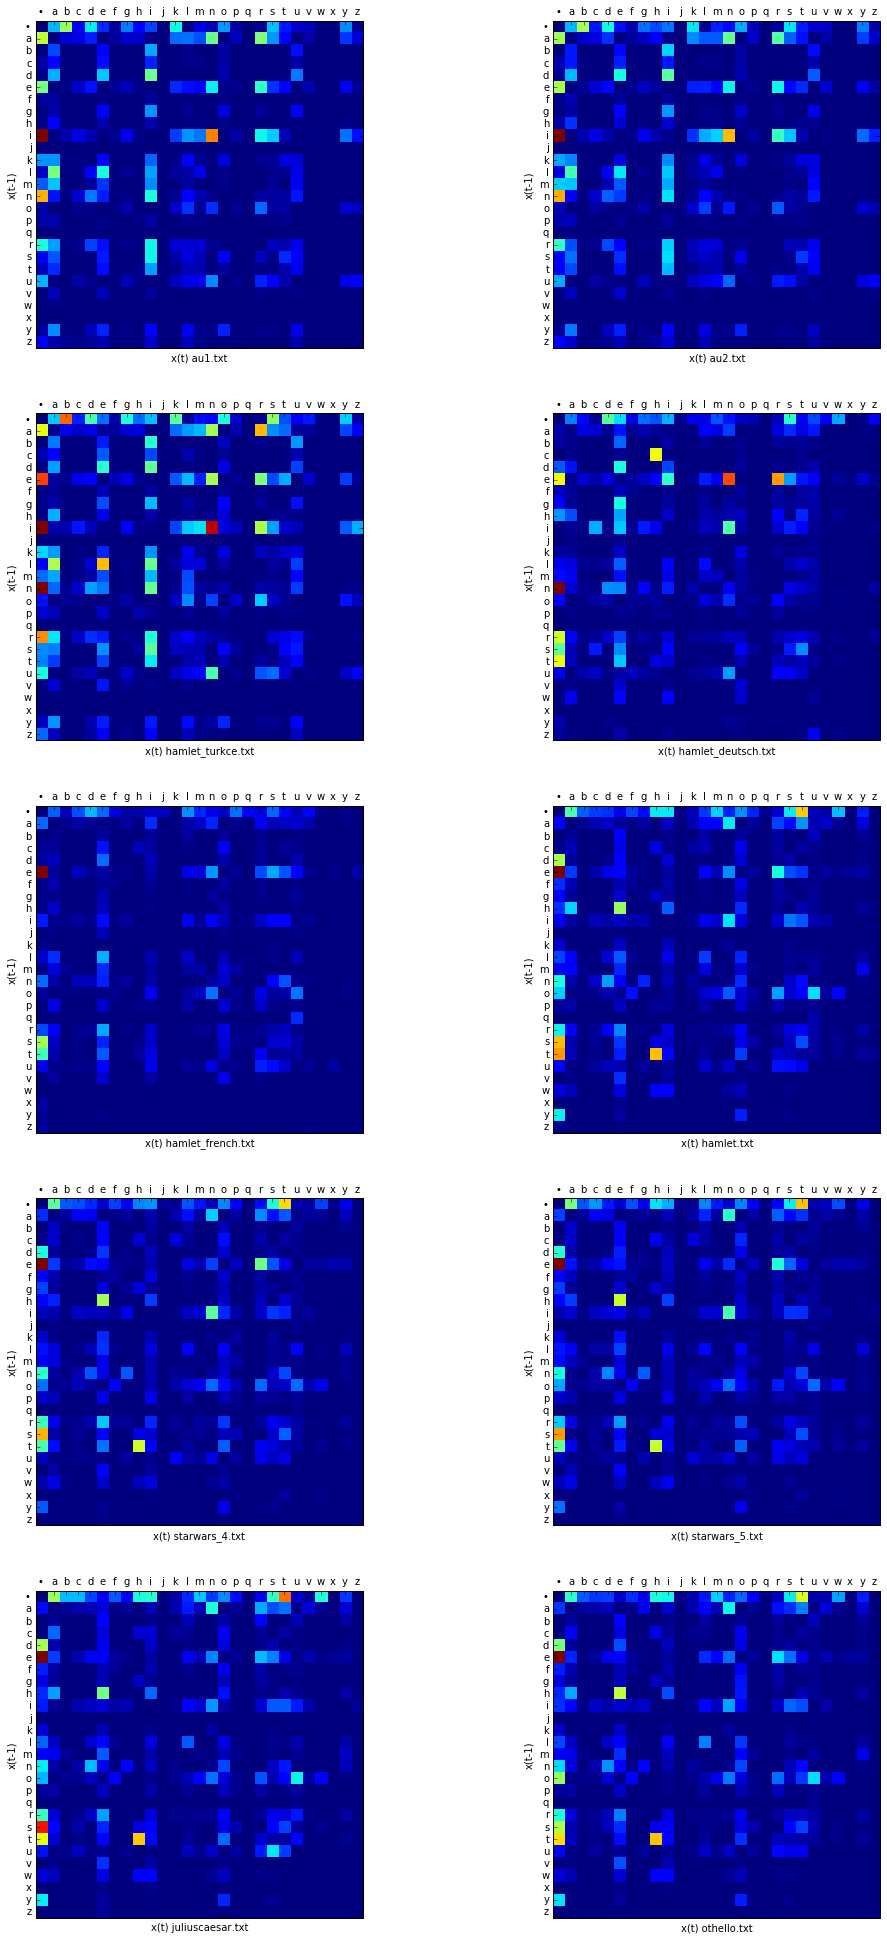

In [9]:
files = ['au1.txt','au2.txt','hamlet_turkce.txt','hamlet_deutsch.txt', 'hamlet_french.txt', 'hamlet.txt','starwars_4.txt', 'starwars_5.txt','juliuscaesar.txt','othello.txt']

plt.figure(figsize=(17,2*17))

i = 0
for f in files:
    url = local+f
    data = urlopen(url)  
    alphabet = ascii_alphabet
    #D, DD, alphabet = count_transitions(data, my_alphabet, {})
    #D, DD, alphabet = count_transitions(data, ascii_alphabet, my2ascii_table)
    data, DD, DDD = count_transitions(data, alphabet, my2ascii_table)
    M = len(alphabet)
    DD[0,0] = 1
    
    i+=1
    plt.subplot(len(files)/2,2,i)
    plt.imshow(DD, interpolation='nearest', vmin=0)
    plt.xticks(range(M), alphabet)
    plt.xlabel('x(t)')
    plt.yticks(range(M), alphabet)
    plt.ylabel('x(t-1)')
    ax = plt.gca()
    ax.xaxis.tick_top()
    #ax.set_title(f, va='bottom')
    plt.xlabel('x(t) '+f)

### Normalized probability table of $p(x_t|x_{t−1})$

hamlet_turkce.txt
time=0,	lhood=-93861.1562

/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:36: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:256: RuntimeWarning: divide by zero encountered in power



online_em_lhood=-66223.7263, duration=6.6026

/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



correction_smoother_lhood=-61440.6793, duration=41.4623


*****


au1.txt
time=0,	lhood=-376653.3566
online_em_lhood=-283019.0720, duration=25.9832
correction_smoother_lhood=-252689.3751, duration=40.4294


*****


au2.txt
time=0,	lhood=-367896.0653
online_em_lhood=-280850.1876, duration=26.1369
correction_smoother_lhood=-254608.6404, duration=40.6245


*****


hamlet_french.txt
time=0,	lhood=-364559.4822
online_em_lhood=-255961.4690, duration=24.8628
correction_smoother_lhood=-241601.0343, duration=40.4027


*****


hamlet.txt
time=0,	lhood=-377639.6240
online_em_lhood=-296782.2432, duration=24.8077
correction_smoother_lhood=-250915.7930, duration=40.6202


*****


starwars_4.txt
time=0,	lhood=-347945.6018
online_em_lhood=-286639.8162, duration=25.1675
correction_smoother_lhood=-255087.3150, duration=40.1327


*****




/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:63: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


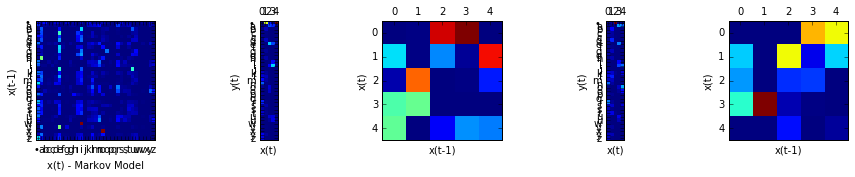

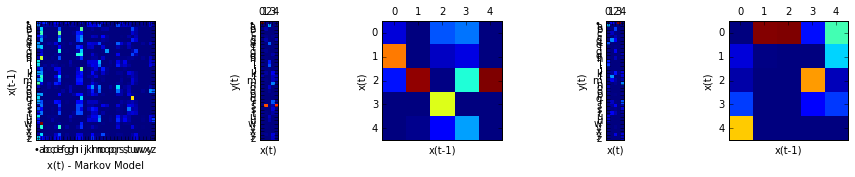

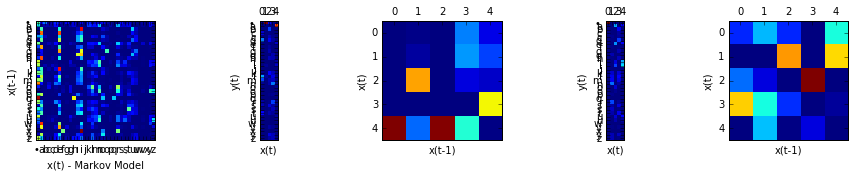

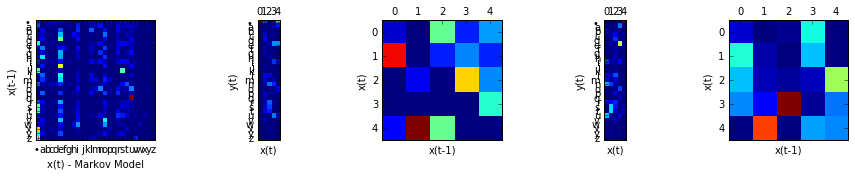

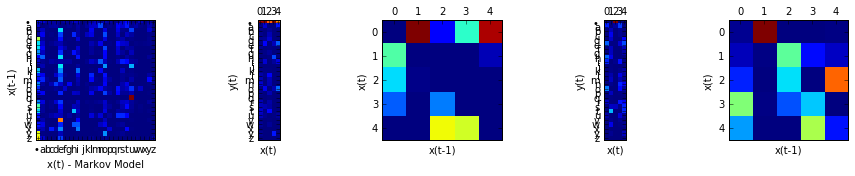

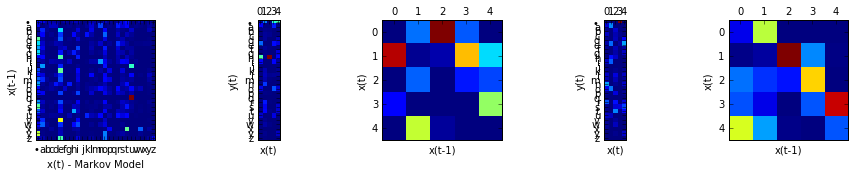

In [10]:
import time

def normalize(A, axis=0):
    Z = np.sum(A, axis=axis,keepdims=True)
    idx = np.where(Z == 0)
    Z[idx] = 1
    return A/Z

files=['hamlet_turkce.txt','au1.txt','au2.txt','hamlet_french.txt', 'hamlet.txt','starwars_4.txt']
alphabets = [tr_alphabet,tr_alphabet,tr_alphabet,ascii_alphabet,ascii_alphabet,ascii_alphabet]
tables = [my2tr_table,my2tr_table,my2tr_table,my2ascii_table,my2ascii_table,my2ascii_table]
cc = 5

for i in range(len(files)):
    table = tables[i]
    alphabet = alphabets[i]
    file_ = files[i]
    print(file_)
    data = urlopen(local+file_) 
    data_vec, DD, DDD = count_transitions(data, alphabet, table)
    T = normalize(DD, axis=1)

    plt.figure(figsize=(15,15))
    
    plt.subplot(len(files),cc,i*cc+1)
    plt.imshow(T, interpolation='nearest', vmin=0)
    plt.xticks(range(len(alphabet)), alphabet)
    plt.yticks(range(len(alphabet)), alphabet)
    plt.xlabel('x(t) - Markov Model')
    plt.ylabel('x(t-1)')

    s = 5
    r = len(alphabet)
    beg = time.time()
    hmm = HMM.from_random_parameters(S=s,R=r)
    hmm.online_em(data_vec[0:1e5],log_interval=1e6)
    end = time.time()
    log_gamma = hmm.forward_backward_smoother(data_vec[0:1e5])
    print ("online_em_lhood=%(lh).4f, duration=%(dur).4f" % {'lh':log_sum_exp(log_gamma[:,0])[0],'dur':end-beg})

    plt.subplot(len(files),cc,i*cc+2)
    plt.imshow(hmm.B, interpolation='nearest', vmin=0)
    plt.xticks(range(s))
    plt.yticks(range(len(alphabet)), alphabet)
    plt.gca().xaxis.tick_top()
    plt.xlabel('x(t)')
    plt.ylabel('y(t)')

    plt.subplot(len(files),cc,i*cc+3)
    plt.imshow(hmm.A, interpolation='nearest', vmin=0)
    plt.xticks(range(s))
    plt.yticks(range(s))
    plt.gca().xaxis.tick_top()
    plt.xlabel('x(t-1)')
    plt.ylabel('x(t)') 

    
    # train with correction smoother
    beg = time.time()
    hmm = HMM.from_random_parameters(S=s,R=r)
    hmm.train_EM(data_vec[0:1e4], EPOCH=50, method='correction_smoother')
    end = time.time()
    log_gamma = hmm.forward_backward_smoother(data_vec[0:1e5])
    print ("correction_smoother_lhood=%(lh).4f, duration=%(dur).4f" % {'lh':log_sum_exp(log_gamma[:,0])[0],'dur':end-beg})
    
    plt.subplot(len(files),cc,i*cc+4)
    plt.imshow(hmm.B, interpolation='nearest', vmin=0)
    plt.xticks(range(s))
    plt.yticks(range(len(alphabet)), alphabet)
    plt.gca().xaxis.tick_top()
    plt.xlabel('x(t)')
    plt.ylabel('y(t)')

    plt.subplot(len(files),cc,i*cc+5)
    plt.imshow(hmm.A, interpolation='nearest', vmin=0)
    plt.xticks(range(s))
    plt.yticks(range(s))
    plt.gca().xaxis.tick_top()
    plt.xlabel('x(t-1)')
    plt.ylabel('x(t)') 
    
    print("\n\n*****\n\n")
    

In [11]:
np.min(5,6)

ValueError: 'axis' entry is out of bounds

In [ ]:
%connect_info